In [2]:
import numpy as np
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import torch.cuda
import time
import math
import torch as t
from numpy import cos,sin,pi,sqrt
import cmath
from scipy.spatial.transform import Rotation as R

In [3]:
def rot(a,b,c):
    a=Tensor([[cos(a),-sin(a),0],[sin(a),cos(a),0],[0,0,1]]).cuda()
    b=Tensor([[cos(b),0,sin(b)],[0,1,0],[-sin(b),0,cos(b)]]).cuda()
    c=Tensor([[1,0,0],[0,cos(c),-sin(c)],[0,sin(c),cos(c)]]).cuda()
    return t.mm(t.mm(a,b),c)

def Rot(c,b,a):
    A=torch.stack([
        torch.stack([t.cos(a),-t.sin(a),t.zeros(len(a)).cuda()]),
        torch.stack([t.sin(a),t.cos(a),t.zeros(len(a)).cuda()]),
        torch.stack([t.zeros(len(a)).cuda(),t.zeros(len(a)).cuda(),t.ones(len(a)).cuda()])
    ]).transpose(0,2).transpose(1,2)
    
    B=torch.stack([
        torch.stack([t.cos(b),t.zeros(len(b)).cuda(),t.sin(b)]),
        torch.stack([t.zeros(len(b)).cuda(),t.ones(len(b)).cuda(),t.zeros(len(b)).cuda()]),
        torch.stack([-t.sin(b),t.zeros(len(b)).cuda(), t.cos(b)])
    ]).transpose(0,2).transpose(1,2)
    
    C=torch.stack([
        torch.stack([t.ones(len(b)).cuda(),t.zeros(len(b)).cuda(),t.zeros(len(b)).cuda()]),
        torch.stack([t.zeros(len(b)).cuda(),t.cos(c),-t.sin(c)]),
        torch.stack([t.zeros(len(b)).cuda(),t.sin(c),t.cos(c)])
    ]).transpose(0,2).transpose(1,2)
    
    return t.matmul(A,t.matmul(B,C))




def WignerD(B):
    U = torch.stack([
                torch.stack([t.cos(B/2)**2, -t.sin(B)/sqrt(2), t.sin(B/2)**2]),
                torch.stack([t.sin(B)/sqrt(2), t.cos(B), -t.sin(B)/sqrt(2)]),
                torch.stack([t.sin(B/2)**2, t.sin(B)/sqrt(2), t.cos(B/2)**2])]).transpose(0,2)
    return U


def poltocart(ep):
    epr=t.matmul(Tensor([[-1/sqrt(2),0,1/sqrt(2)],[0,0,0],[0,1,0]]).cuda().unsqueeze(0).repeat(ep.shape[0],1,1),ep)
    epc=t.matmul(Tensor([[0,0,0],[1/sqrt(2),0,1/sqrt(2)],[0,0,0]]).cuda().unsqueeze(0).repeat(ep.shape[0],1,1),ep)
    
    
    
    return epr,epc



def carttopol(ep):
    epr=ep[0]
    epc=ep[1]
    epr1=t.matmul(Tensor([[-1/sqrt(2),0,0],[0,0,1],[1/sqrt(2),0,0]]).cuda().unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epr)
    epr2=t.matmul(Tensor([[0,1/sqrt(2),0],[0,0,0],[0,1/sqrt(2),0]]).cuda().unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epc)
    
    epc1=t.matmul(Tensor([[-1/sqrt(2),0,0],[0,0,1],[1/sqrt(2),0,0]]).cuda().unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epc)
    epc2=t.matmul(Tensor([[0,-1/sqrt(2),0],[0,0,0],[0,-1/sqrt(2),0]]).cuda().unsqueeze(0).unsqueeze(1).repeat(epr.shape[0],epr.shape[1],1,1),epr)
    
    epr=epr1+epr2
    epc=epc1+epc2
    
    ep=t.norm(t.cat((epr.unsqueeze(0),epc.unsqueeze(0)),0),dim=0)
    return(ep)
    
    
    
    
def Mvect_outer(vector, Matrix):
    vector*Matrix
    
    

    
    
E=Tensor([pi/2,pi,2*pi,pi/2]).cuda()
x=Tensor([[1,0,0],[-1,0,0],[0,1,0],[0,0,1]]).cuda().unsqueeze(2)
x=poltocart(x)
print(x)





#t.matmul(Rot(E,t.zeros(4).cuda(),t.zeros(4).cuda()),x)



(tensor([[[-0.7071],
         [ 0.0000],
         [ 0.0000]],

        [[ 0.7071],
         [ 0.0000],
         [ 0.0000]],

        [[ 0.0000],
         [ 0.0000],
         [ 1.0000]],

        [[ 0.7071],
         [ 0.0000],
         [ 0.0000]]], device='cuda:0'), tensor([[[ 0.0000],
         [ 0.7071],
         [ 0.0000]],

        [[ 0.0000],
         [-0.7071],
         [ 0.0000]],

        [[ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 0.0000],
         [ 0.7071],
         [ 0.0000]]], device='cuda:0'))


In [4]:
class particles():
    
    
    def create(N, R, T, m, F_l, F_u):
        k_B=1.3806503e-23
        lamb=np.sqrt((2*k_B*T)/m)
        
        #picking a point on a quadrant on the surface of the sphere
        z=t.zeros((N)).cuda().uniform_()
        theta=t.arcsin(z).cuda()
        phi=t.zeros((N)).cuda().uniform_(0,np.pi/2)
        x=t.zeros(N,3).cuda()
        x[:,0]=t.sqrt(1-z**2)*t.cos(phi)
        x[:,1]=t.sqrt(1-z**2)*t.sin(phi)
        x[:,2]=z
        
        v=t.zeros((N,3)).to('cuda').uniform_(0,1)
        v=-(lamb/1.2)*t.arctanh(v) #mapping from uniform to positive Max.boltz. distribution (see notes)
        
        e=1-2*t.zeros((N,3)).cuda().random_(0,2) #creates an N*3 matrix of ones and minus ones
        particles.x=R*e*x
        particles.v=e*v
        particles.l=(t.ones((N,2*F_l+1))/(2*(F_l+1))).cuda()
        particles.u=(t.zeros((N,2*F_u+1))).cuda()
        
    def createbyinp(pos,vel,F_l,F_u):
        N=len(pos[:,0])
        particles.x=Tensor(pos).cuda()
        particles.v=Tensor(vel).cuda()
        particles.l=(t.ones((N,2*F_l+1))/(2*(F_l+1))).cuda()
        particles.u=(t.zeros((N,2*F_u+1))).cuda()

class Rubidium:
    mass=1.455181063e-25 #mass given in kilograms
    l=2  #This variable defines the angular momentum of the lower state.
    u=3  #This variable defines the angular momentum of the upper state.
    gl=1/2  #This variable defines the g-factor for the lower states.
    gu=2/3  #This variable defines the g-factor for the upper states.
    Gamma=38.11e6  #this is the natural decay rate in s^-1
    
    
    BranRat=Tensor([
        [15/21,5/21,1/21,0,0,0,0],
        [0,10/21,8/21,3/21,0,0,0],
        [0,0,6/21,9/21,6/21,0,0],
        [0,0,0,3/21,8/21,10/21,0],
        [0,0,0,0,1/21,5/21,15/21]
    ]).cuda() #This tensor encodes the branching ratio/CB coeff, which are used for calculating the transition rates.
    
    
    

class Environment():            
    #define lasers by intensity in their k-vector. (i.e. give directionality and orientation.)
    Lk=torch.zeros(6,3).cuda()
    for i in range(0,6):
        #define 6 orth. laser unit k-vectors.
        Lk[i,int(i/2)]=2*((i+1)%2)-1
        
    Lpol=torch.zeros(6,3).cuda()
    for i in range(0,4):
        #define polarization using (ep+,pi,ep-)
        Lpol[i,0]=1
    for i in range(4,6):
        #z has opposite polarization to k-vector, +z --> ep-
        Lpol[i,0]=1
        
    
    rinit=Rot(Tensor([0,0,pi/2,-pi/2,0,pi]).cuda(),Tensor([-pi/2,pi/2,0,0,0,0]).cuda(),Tensor([0,0,0,0,0,0]).cuda()) #this initializes the rotation tensor
    Lpolcart=poltocart(Lpol.unsqueeze(2))
    LpolcartR=t.matmul(rinit,Lpolcart[0])
    LpolcartI=t.matmul(rinit,Lpolcart[1])
    

    
    
    dtun=2*np.pi*12e6 #laser power detunement in rad/s
    A=0.15 #Magnetic field gradient in T/m
    B=Tensor([A,A,-2*A]).cuda() #
    LAnFr=2.4141913346e15  #Laser angular frequency (neednt be exact)
    rad=20000 #gaussian radius of the beams
    cutoff=10 #cutoff radius of the beams
    hbar=1.055e-34 #reduced planck constant in J/s
    c=3e8 #speed of light in m/s
    Is=hbar*4*pi**3*Rubidium.Gamma*LAnFr**3/(27*c**2) #saturation intensity in W m^-2
    #Is=2.0
    
    Imax=50.0 #maximum beam intensity in Watt m^-2
    Kmag=LAnFr/c  #photon momentum vector magnitude
    Kmag2=Kmag**2  #momentum vector squared important later.
    gravity=Tensor([0,0,-9.81]).cuda().unsqueeze(0)  #gravity accelaration tensor in m s^-2
    
    def Intensities(x):
        pos=t.cat(((x[:,1]**2+x[:,2]**2).unsqueeze(1),(x[:,0]**2+x[:,2]**2).unsqueeze(1)),dim=1)
        pos=t.cat((pos,(x[:,0]**2+x[:,1]**2).unsqueeze(1)),dim=1)
        Int=t.pow(np.e,-(t.pow(pos,2)/Environment.rad)).repeat(1,2)
        Int=t.index_select(Int,1,t.LongTensor([0,3,1,4,2,5]).cuda())
        Int=Int*Environment.Imax/Environment.Is
        return Int
    
    
    
    def Veldtun(v):
        kv = t.inner(Environment.Lk,v)
        return -kv*Environment.Kmag
    
    
    def Bdtun(Ml,Mu,x):
        return 8.7941e10*torch.sqrt(torch.sum(torch.square(Environment.B*x),1))*(Rubidium.gl*Ml-Rubidium.gu*Mu)
    
    def eploc(x):
        R1=Environment.Brot(Environment.B,x).unsqueeze(1).repeat(1,6,1,1)
        epr=Environment.LpolcartR.unsqueeze(0).repeat(x.shape[0],1,1,1)
        epc=Environment.LpolcartI.unsqueeze(0).repeat(x.shape[0],1,1,1)
        epr=t.matmul(R1,epr)
        epc=t.matmul(R1,epc)
        ep=carttopol([epr,epc])
        ep=ep
        return ep
        
    
        
    def Brot(B,x):
        u=F.normalize(t.matmul(Tensor([[0,1,0],[-1,0,0],[0,0,0]]).cuda().unsqueeze(0).repeat(x.shape[0],1,1),(B*x).unsqueeze(2)).squeeze())
        W=t.inner(Tensor([[[0,0,0],[0,0,-1],[0,1,0]],[[0,0,1],[0,0,0],[-1,0,0]],[[0,-1,0],[1,0,0],[0,0,0]]]).cuda(),u).transpose(1,2).transpose(0,1)

        phi=-t.arccos(F.normalize(x)[:,2])
        
        Id=Tensor([[1,0,0],[0,1,0],[0,0,1]]).cuda().unsqueeze(0).repeat(x.shape[0],1,1)
        
        R=Id+(W.transpose(0,2)*t.sin(phi)).transpose(0,2)+((t.matmul(W,W)).transpose(0,2)*(2*t.sin(phi/2)**2)).transpose(0,2)
        
        
        
        return R
    
    
    
    
    
    def fulldtun(Ml,Mu):
        return (Environment.dtun-Environment.Veldtun(particles.v)-Environment.Bdtun(Ml,Mu,particles.x)).transpose(0,1)
    

    
    
        
    
    

def RatesbyBeam(u,l,Pa,En,Rb):
    s=En.Intensities(Pa.x)
    den=(1+4*(En.fulldtun(l,u)/Rb.Gamma)**2+s)
    Rate=s*Rb.Gamma/2*En.eploc(Pa.x)[:,:,(1+(l-u)),0]/den
    Rate=Rate*t.sqrt(Rb.BranRat[l+2,u+3])
    return Rate
    




'''

particles.create(5000,2,1,Rubidium.mass,Rubidium.l,Rubidium.u)
x=Tensor([[0,1,0],[1,-1,1/2]]).cuda()
z=Tensor([[2,3,5],[0,0,1]]).cuda()
print(Environment.Intensities(particles.x).shape)

#print(RatesbyBeam(3,2,particles,Environment,Rubidium)[0])
print(Environment.eploc(x))
print(Rubidium.BranRat.shape)
print(Environment.Lpolcart)'''

'\n\nparticles.create(5000,2,1,Rubidium.mass,Rubidium.l,Rubidium.u)\nx=Tensor([[0,1,0],[1,-1,1/2]]).cuda()\nz=Tensor([[2,3,5],[0,0,1]]).cuda()\nprint(Environment.Intensities(particles.x).shape)\n\n#print(RatesbyBeam(3,2,particles,Environment,Rubidium)[0])\nprint(Environment.eploc(x))\nprint(Rubidium.BranRat.shape)\nprint(Environment.Lpolcart)'

In [5]:
particles.create(5000,2,1,Rubidium.mass,Rubidium.l,Rubidium.u)

(array([[491., 473., 505., 514., 540., 530., 475., 442., 516., 514.],
        [501., 481., 504., 509., 525., 479., 503., 510., 491., 497.],
        [507., 523., 495., 473., 493., 495., 507., 518., 478., 511.]]),
 array([-1.9998716e+00, -1.5999099e+00, -1.1999481e+00, -7.9998636e-01,
        -4.0002459e-01, -6.2823296e-05,  3.9989895e-01,  7.9986072e-01,
         1.1998224e+00,  1.5997843e+00,  1.9997460e+00], dtype=float32),
 <a list of 3 BarContainer objects>)

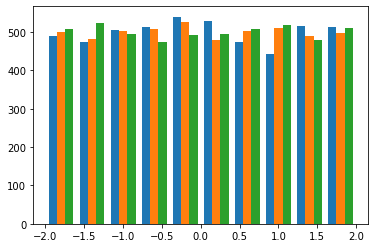

In [6]:
plt.hist(particles.x.transpose(0,1).to('cpu'))

In [7]:
Rates=t.zeros((particles.x.shape[0],6,5,7)).cuda()
#calculate rate eqns:
for l in range(-2,3):
    for u in range(-3,4):
        if abs(l-u)<2:
            Rates[:,:,l+2,u+3]=RatesbyBeam(u,l,particles,Environment,Rubidium)
print(Rates.shape)
print(particles.l.shape)
RNl=t.mul(Rates.transpose(2,3).transpose(0,2),particles.l).transpose(0,2).transpose(2,3)
RNu=t.mul(Rates.transpose(0,2),particles.u).transpose(0,2)
print(RNu.shape,RNl.shape)
print(t.sum(RNu-RNl,(1,2,3)))
print(Rubidium.BranRat.shape)

torch.Size([5000, 6, 5, 7])
torch.Size([5000, 5])
torch.Size([5000, 6, 5, 7]) torch.Size([5000, 6, 5, 7])
tensor([-44429.6367,  -7216.7168, -41833.3320,  ..., -13989.2988,
         -7474.0938, -23630.5664], device='cuda:0')
torch.Size([5, 7])


In [31]:

def forward(Pa=particles,En=Environment,Ru=Rubidium,timestep=0.0001,ratemults=100,timeforward=0.1):
    
    Rates=t.zeros((Pa.x.shape[0],6,5,7)).cuda()
    #calculate rate eqns:
    for l in range(-2,3):
        for u in range(-3,4):
            if abs(l-u)<2:
                Rates[:,:,l+2,u+3]=RatesbyBeam(u,l,Pa,En,Ru)
        
    
    
    Rats=t.sum(Rates,1)
    Pnr=Pa.x.shape[0]
    '''
    neoz=t.zeros((Pnr),device='cuda')
    R=torch.stack([
        torch.stack([Rats[:,-2,-3],Rats[:,-2,-2],Rats[:,-2,-1],neoz,neoz,neoz,neoz]),
        torch.stack([neoz,Rats[:,-1,-2],Rats[:,-1,-1],Rats[:,-1,0],neoz,neoz,neoz]),
        torch.stack([neoz,neoz,Rats[:,0,-1],Rats[:,0,0],Rats[:,0,1],neoz,neoz]),
        torch.stack([neoz,neoz,neoz,Rats[:,1,0],Rats[:,1,1],Rats[:,1,2],neoz]),
        torch.stack([neoz,neoz,neoz,neoz,Rats[:,2,1],Rats[:,2,2],Rats[:,2,3]]),
    ])
    '''
    
    
    Br=Ru.BranRat.unsqueeze(0).repeat(Pa.x.shape[0],1,1)
    dt=timestep
    mul=ratemults
    Accel=t.zeros(Pa.x.shape,device='cuda')
    for i in range(mul):
        RNl=t.mul(Rates.transpose(2,3).transpose(0,2),Pa.l).transpose(0,2).transpose(2,3)
        RNu=t.mul(Rates.transpose(0,2),Pa.u).transpose(0,2)
        Rachang=t.sum(RNl-RNu,(2,3))


        Accel+=(Environment.hbar*Environment.Kmag/Rubidium.mass* t.matmul(Rachang.unsqueeze(1).unsqueeze(1),Environment.Lk.unsqueeze(0).unsqueeze(3).transpose(1,2)).squeeze())/mul




        #Pa.l+=(Ru.Gamma*t.matmul(Br,Pa.u.unsqueeze(2)).squeeze()+t.sum(RNu-RNl,(1,3)))*dt/mul
        #Pa.u+=(-Ru.Gamma*Pa.u+t.sum(RNl-RNu,(1,2)))*dt/mul


    
    #Pa.v=Pa.v+Accel*dt
    #Pa.x=Pa.x+Pa.v*dt
    return Accel,Rates




'''
def forward(Pa,gravity,Ru,var):
    
    dt=var['timestep']
    mul=var['ratemults']
    
    Accel=gravity-Pa.v*0.1-Pa.x*0.1
    
    Pa.v=Pa.v+Accel*dt
    Pa.x=Pa.x+Pa.v*dt


'''



    


    

"\ndef forward(Pa,gravity,Ru,var):\n    \n    dt=var['timestep']\n    mul=var['ratemults']\n    \n    Accel=gravity-Pa.v*0.1-Pa.x*0.1\n    \n    Pa.v=Pa.v+Accel*dt\n    Pa.x=Pa.x+Pa.v*dt\n\n\n"

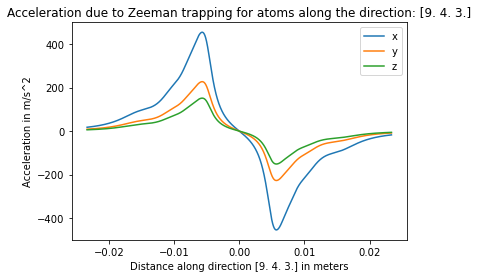

tensor(254543.9688, device='cuda:0')


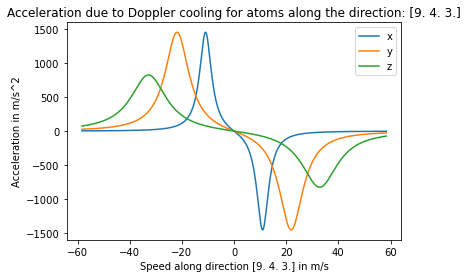

In [32]:
if False: #zeeman in x
    xsh,ysh,zsh=2000,1,1
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.3,0.3,xsh),t.linspace(-0.01,0.9,ysh),t.linspace(-0.01,0.5,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    #Rates=forward().unsqueeze(0).unsqueeze(0)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(2)
    #Rates=Rates.reshape(xsh,ysh,zsh,6)
    #print(Rates[0,1500,0])
    #print(particles.x[1500])
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,xsh,endpoint=True),Accel[:,0,0,0].cpu().numpy())
    plt.show()
    
if False: #zeeman in y
    xsh,ysh,zsh=1,2000,1
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.01,0.9,xsh),t.linspace(-0.3,0.3,ysh),t.linspace(-0.01,0.5,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    #Rates=forward().unsqueeze(0).unsqueeze(0)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(2)
    #Rates=Rates.reshape(xsh,ysh,zsh,6)
    #print(Rates[0,1500,0])
    #print(particles.x[1500])
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,ysh,endpoint=True),Accel[0,:,0,1].cpu().numpy())
    plt.show()
    
if False: #zeeman in z
    xsh,ysh,zsh=1,1,2000
    pos=t.zeros((3,xsh,ysh,zsh))
    pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.01,0.0,xsh),t.linspace(-0.01,0.9,ysh),t.linspace(-0.3,0.3,zsh))
    pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    vel=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    #Rates=forward().unsqueeze(0).unsqueeze(0)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(0)
    #Rates=Rates.reshape(xsh,ysh,zsh,6)
    #print(Rates[0,1500,0])
    #print(particles.x[1500])
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.3,0.3,zsh,endpoint=True),Accel[int(xsh/2),0,:,2].cpu().numpy())
    plt.show()
    
    
if False: #doppler in z
    xsh,ysh,zsh=5,5,2000
    vel=t.zeros((3,xsh,ysh,zsh))
    vel[0],vel[1],vel[2]=t.meshgrid(t.linspace(-25,25,xsh),t.linspace(-25,25,ysh),t.linspace(-25,25,zsh))
    vel=vel.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
    pos=t.zeros((xsh*ysh*zsh,3)).numpy()
    particles.createbyinp(pos,vel,2,3)
    Accel,Rates=forward()
    Accel=Accel.unsqueeze(0).unsqueeze(0)
    Rates=Rates.unsqueeze(0).unsqueeze(2)
    Accel=Accel.reshape(xsh,ysh,zsh,3)
    plt.plot(np.linspace(-0.5,0.5,zsh,endpoint=True),Accel[int(xsh/2),int(ysh/2),:,2].cpu().numpy())
    plt.show
    
if True: #zeeman along a given direction
    direction=0.02*np.array([1,1/2,1/3])
    num=5000
    d=np.linalg.norm(direction)
    pos=t.zeros((3,num))
    pos[0]=t.linspace(-direction[0],direction[0],num)
    pos[1]=t.linspace(-direction[1],direction[1],num)
    pos[2]=t.linspace(-direction[2],direction[2],num)
    pos=pos.transpose(0,1)
    vel=t.zeros((3,num)).transpose(0,1)
    particles.createbyinp(pos,vel,2,3)
    Accel,Rates=forward()
    A=Accel.cpu().numpy()
    plt.title('Acceleration due to Zeeman trapping for atoms along the direction: '+str(np.round(10*direction/d)))
    plt.plot(np.linspace(-d,d,num),A[:,0],label='x')
    plt.plot(np.linspace(-d,d,num),A[:,1],label='y')
    plt.plot(np.linspace(-d,d,num),A[:,2],label='z')
    plt.xlabel('Distance along direction ' +str(np.round(10*direction/d))+' in meters')
    plt.ylabel('Acceleration in m/s^2')
    plt.legend()
    plt.show()
    print(t.max(Rates))
    
if True: #doppler along a given direction
    direction=50*np.array([1,1/2,1/3])
    d=np.linalg.norm(direction)
    num=5000
    vel=t.zeros((3,num))
    vel[0]=t.linspace(-direction[0],direction[0],num)
    vel[1]=t.linspace(-direction[1],direction[1],num)
    vel[2]=t.linspace(-direction[2],direction[2],num)
    vel=vel.transpose(0,1)
    pos=t.zeros((3,num)).transpose(0,1)
    particles.createbyinp(pos,vel,2,3)
    Accel,Rates=forward()
    A=Accel.cpu().numpy()
    plt.title('Acceleration due to Doppler cooling for atoms along the direction: '+str(np.round(10*direction/d)))
    plt.plot(np.linspace(-d,d,num),A[:,0],label='x')
    plt.plot(np.linspace(-d,d,num),A[:,1],label='y')
    plt.plot(np.linspace(-d,d,num),A[:,2],label='z')
    plt.xlabel('Speed along direction ' +str(np.round(10*direction/d))+' in m/s')
    plt.ylabel('Acceleration in m/s^2')
    plt.legend()
    plt.show()


In [26]:
print(Environment.eploc(particles.x).shape)

torch.Size([5000, 6, 3, 1])


In [ ]:
print(forward(particles,Environment,Rubidium,simulation_variables)[0])

AttributeError: type object 'particles' has no attribute 'x'

In [ ]:
xsh,ysh,zsh=5,5,2000
pos=t.zeros((3,xsh,ysh,zsh))
pos[0],pos[1],pos[2]=t.meshgrid(t.linspace(-0.5,0.5,xsh),t.linspace(-0.5,0.5,ysh),t.linspace(-0.5,0.5,zsh))
pos=pos.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
vel=t.zeros((xsh*ysh*zsh,3)).numpy()
particles.createbyinp(pos,vel,2,3)

In [ ]:

xsh,ysh,zsh=5,5,2000
vel=t.zeros((3,xsh,ysh,zsh))
vel[0],vel[1],vel[2]=t.meshgrid(t.linspace(-25,25,xsh),t.linspace(-25,25,ysh),t.linspace(-25,25,zsh))
vel=vel.reshape(3,xsh*ysh*zsh).transpose(0,1).numpy()
pos=t.zeros((xsh*ysh*zsh,3)).numpy()
particles.createbyinp(pos,vel,2,3)

In [ ]:
Environment.Lk.unsqueeze(0)

tensor([[[ 1.,  0.,  0.],
         [-1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0., -1.,  0.],
         [ 0.,  0.,  1.],
         [ 0.,  0., -1.]]], device='cuda:0')